In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

from projection_vi.flows import ComponentwiseFlow, RealNVP, AffineFlow
from projection_vi.train import train, iterative_AS_mfvi
from projection_vi.utils import softplus, inverse_softplus

Field system target

$$
-\log p(x) = \beta\cdot \Big[\frac{ad}{2}\sum_{i=1}^{d+1}(x_i-x_{i-1})^2 + \frac{1}{4ad}\sum_{i=1}^d (1-x_i)^2 \Big]
$$
where $x_0=x_{d+1}=0$

In [3]:
a = .1
beta = 5.
d = 64

class field_system:
    def __init__(self, d, a=0.1, beta=20):
        self.d = d
        self.a = a
        self.beta = beta

        # precondition
        C = 2 * jnp.eye(d) + jnp.diag(-jnp.ones(d-1), k=1) + jnp.diag(-jnp.ones(d-1), k=-1)
        base_prec = beta * (a * d * C + (1 / a / d) * jnp.eye(d))
        chol = jnp.linalg.cholesky(base_prec).T
        self.scale = jnp.linalg.inv(chol)
    
    def log_prob(self, x):
        x = self.scale @ x
        return -self.beta * ((self.a * self.d / 2) * (jnp.sum(jnp.diff(x)**2) + x[0]**2 + x[-1]**2) + 1 / (self.a * 4 * self.d) * jnp.sum((1 - x**2)**2))

    def param_constrain(self, X):
        return X @ self.scale.T

Informed base measure

$$
-\log p(x) = \beta\cdot \Big[\frac{ad}{2}\sum_{i=1}^{d+1}(x_i-x_{i-1})^2 + \frac{1}{2ad}\sum_{i=1}^d x_i^2 \Big]
$$
We can write
$$
\sum_{i=1}^{d+1}(x_i-x_{i-1})^2 = x^\top C x, 
$$
where $C$ has diagonals all equal to 2, and 1-off-diagonals all equal to -1.

This corresponds to the Gaussian distribution $N(0, (1/\beta) (ad C + (1/ad) I_d )^{-1} )$.

In [4]:
model = ComponentwiseFlow(d=d, num_bins=10, range_min=-8, range_max=8, boundary_slopes='unconstrained')
niter = 1
learning_rate = 0.01
max_iter = 500
n_train = 2000
n_val = 500
key = jax.random.key(1)
key, subkey = jax.random.split(key)
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]

In [5]:
betas = [5., 10., 15., 20.]
transformed_samples = []
for beta in betas:
    print("beta =", beta)
    target = field_system(d, a, beta)
    key, subkey = jax.random.split(key)
    if beta == 5.:
        rank0 = 1
    else:
        rank0 = 0
    samples, logs = iterative_AS_mfvi(model, target.log_prob, niter=niter, key=subkey, base_samples=base_samples, val_samples=base_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=rank0)
    base_samples = samples[0]
    transformed_samples.append(target.param_constrain(base_samples))

beta = 5.0


Running for 500 iterations: 100%|██████████| 500/500 [00:07<00:00, 70.84it/s]


Iteration: 0 KL: -54.667847 ESS: 79.549614
beta = 10.0


Running for 500 iterations: 100%|██████████| 500/500 [00:07<00:00, 71.07it/s]


Iteration: 0 KL: -55.60754 ESS: 5.853525
beta = 15.0


Running for 500 iterations: 100%|██████████| 500/500 [00:07<00:00, 70.09it/s]


Iteration: 0 KL: -53.571407 ESS: 4.341549
beta = 20.0


Running for 500 iterations: 100%|██████████| 500/500 [00:07<00:00, 69.38it/s]

Iteration: 0 KL: -56.28865 ESS: 2.0847516


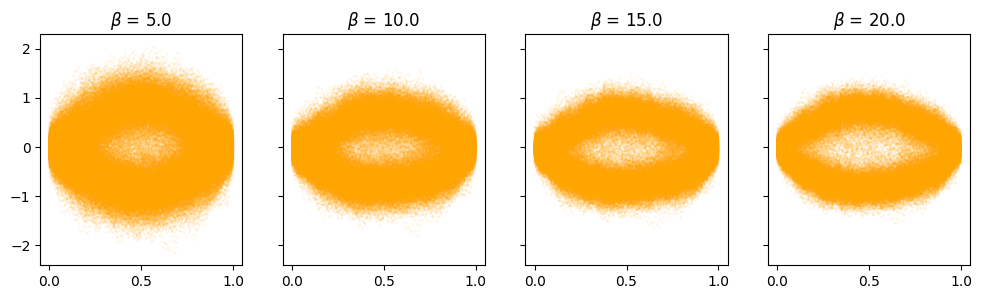

In [6]:
ts = jnp.linspace(0, 1, d)
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True, sharex=True)
for k in range(4):
    for j in range(0, n_train):
        ax[k].plot(ts, transformed_samples[k][j, :], c='orange', alpha=.1, ls=':')
        ax[k].set_title(fr"$\beta$ = {betas[k]}")   

## RealNVP

In [7]:
model_nvp = RealNVP(dim=d, n_layers=8, hidden_dims=[d])
key, subkey = jax.random.split(key)
params_nvp = model_nvp.init(subkey, jnp.zeros((1, d)))

target = field_system(d, a, 20)

key = jax.random.key(1)
key, subkey = jax.random.split(key)
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]

@jax.jit
def loss_nvp(params_nvp):
    return model_nvp.apply(params_nvp, base_samples, target.log_prob, method=model_nvp.reverse_kl)

learning_rate = 1e-3
max_iter = 2000
params_nvp, losses_nvp = train(loss_nvp, params_nvp, learning_rate=learning_rate, max_iter=max_iter)

Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:18<00:00, 107.62it/s]


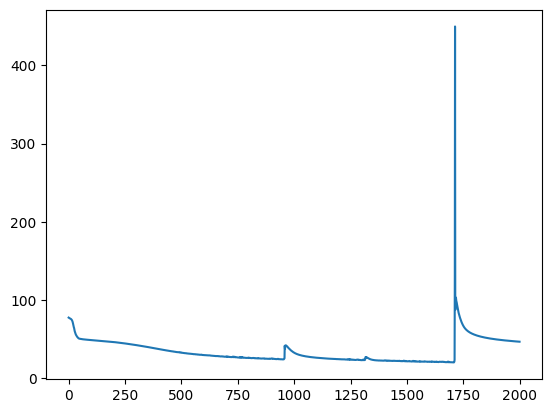

In [8]:
plt.plot(losses_nvp)

In [9]:
samples_nvp, _ = model_nvp.apply(params_nvp, base_samples, method=model_nvp.forward)

In [10]:
transformed_samples_nvp = target.param_constrain(samples_nvp)

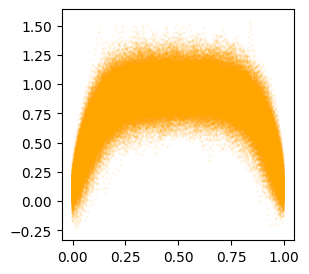

In [11]:
ts = jnp.linspace(0, 1, d)
plt.figure(figsize=(3, 3))
for j in range(n_train):
    plt.plot(ts, transformed_samples_nvp[j, :], c='orange', alpha=.1, ls=':')

TODO: For fair comparison, add annealing to the training of NF; also, make the number of parameters and training iterations comparable.